In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from pathlib import Path

In [4]:
#path = Config.data_path()/'planet'
#path.mkdir(exist_ok=True)
path = Path('/scratch/planet/')/'planet'
path

PosixPath('/scratch/planet/planet')

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

404 - Not Found
404 - Not Found
unzip:  cannot find or open /home/kritika.prakash/.fastai/data/planet/train_v2.csv.zip, /home/kritika.prakash/.fastai/data/planet/train_v2.csv.zip.zip or /home/kritika.prakash/.fastai/data/planet/train_v2.csv.zip.ZIP.


In [5]:
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [14]:
??ImageList.from_csv

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [9]:
data.train_ds[0]

(Image (3, 128, 128),
 MultiCategory [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.])

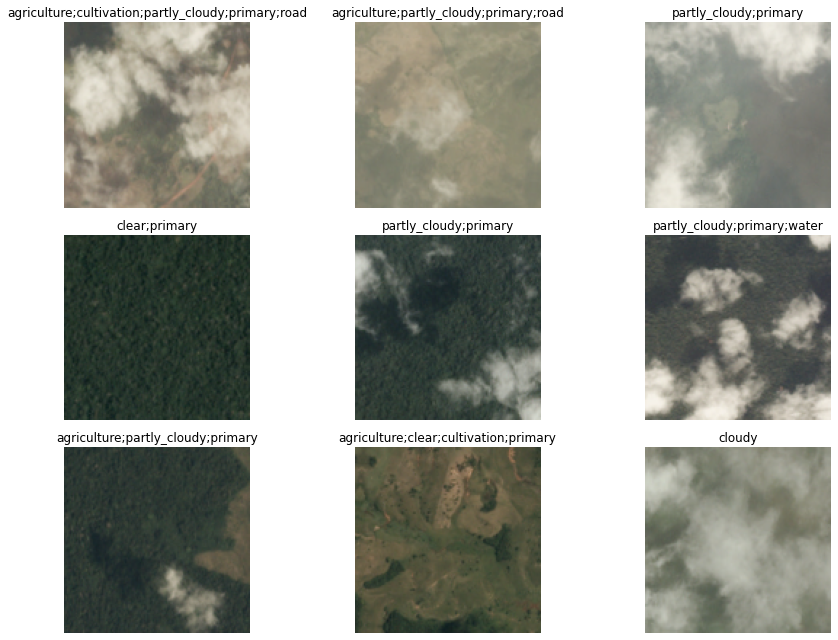

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [10]:
arch = models.resnet50

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
learn.loss_fn

AttributeError: 'Learner' object has no attribute 'loss_fn'

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


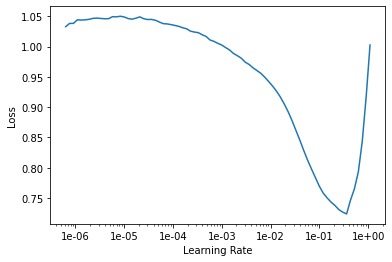

In [24]:
learn.recorder.plot()

In [25]:
lr = 0.01

In [26]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136848,0.120601,0.939215,0.896627,03:07
1,0.108554,0.098639,0.952491,0.914452,03:02
2,0.103362,0.095889,0.954402,0.914631,02:59
3,0.093720,0.088803,0.956560,0.921407,03:00
4,0.093015,0.087080,0.956131,0.923934,02:56


In [28]:
learn.save('stage-1-rn50')

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


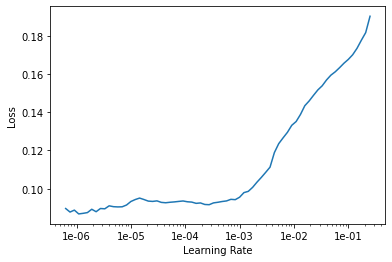

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094667,0.092176,0.956749,0.920751,02:53
1,0.097809,0.088326,0.953472,0.924246,02:57
2,0.093598,0.085168,0.958900,0.927481,02:59
3,0.083405,0.083025,0.958362,0.928100,02:54
4,0.081769,0.082886,0.959714,0.929293,02:55


In [32]:
learn.save('stage-2-rn50')

In [33]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [34]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


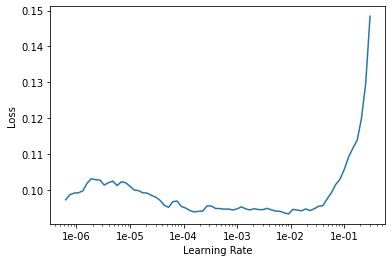

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
lr=1e-2/2

In [37]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087285,0.085012,0.957636,0.925312,03:46
1,0.085693,0.085675,0.959786,0.927738,03:46
2,0.086753,0.083426,0.959161,0.926256,04:35
3,0.083167,0.081389,0.958711,0.930778,03:49
4,0.079251,0.081163,0.958173,0.930713,04:46


In [1]:
learn.save('stage-1-256-rn50')

NameError: name 'learn' is not defined

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

## Part 2 Image Segmentation with CamVid

In [16]:
path = untar_data(URLs.CAMVID)

A new version of the dataset is available.


In [18]:
path.ls()

[PosixPath('/home/kritika.prakash/.fastai/data/camvid/images'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/labels'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/valid.txt')]

In [19]:
path_lbl = path/'labels'
path_img = path/'images'

In [20]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/kritika.prakash/.fastai/data/camvid/images/Seq05VD_f01920.png'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/images/0006R0_f02190.png'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/images/0006R0_f03720.png')]

In [21]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/kritika.prakash/.fastai/data/camvid/labels/0001TP_007860_P.png'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/labels/0016E5_07991_P.png'),
 PosixPath('/home/kritika.prakash/.fastai/data/camvid/labels/0006R0_f02400_P.png')]

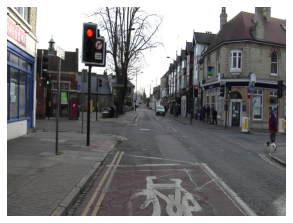

In [22]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [23]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

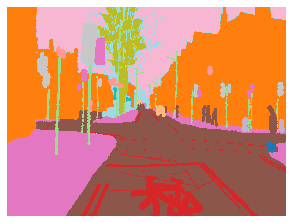

In [24]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [25]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [26]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [32]:
size = src_size//2
bs = 8
# free = utils.mem.gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")